<a href="https://colab.research.google.com/github/heejjj/Sleeping_Project/blob/main/binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# weekday binary 

In [6]:
weekday = pd.read_csv('/content/drive/MyDrive/KDT_project/Hackathon/CNNsegmentation/data/weekday.csv')
weekday = weekday.drop('Unnamed: 0', axis=1)
print(weekday.shape)

(1434, 7)


In [7]:
weekday["Duration (hr)"] = weekday["Duration (hr)"].astype('float') * 1000
weekday['Value']= weekday['Value'].replace('Core',1)
weekday['Value']= weekday['Value'].replace('REM',0)
weekday['Value']= weekday['Value'].replace('Deep',0)
weekday['Value']= weekday['Value'].replace('Awake',0)
tmp = weekday[["Duration (hr)", "Value"]]
tmp = np.array(tmp)

x_list = []
for x in tmp:
  if x[1] != 0:
    timeseries = np.ones([int(x[0])]) * x[1]
    x_list.append(timeseries)
  else:
    timeseries = np.zeros([int(x[0])])
    x_list.append(timeseries)

ts = np.concatenate(x_list)
print(ts.shape)

(378383,)


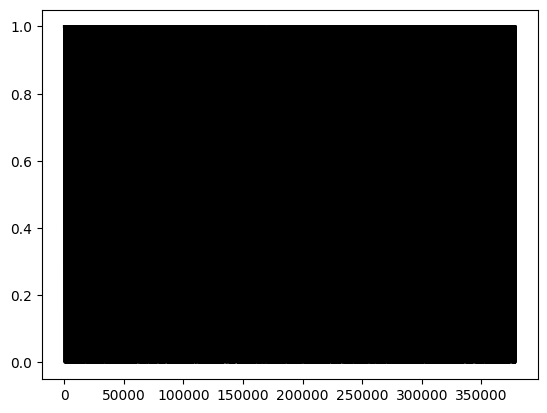

In [12]:
y = ts
x = np.arange(len(y))

plt.plot(x, y, color='black',linewidth=2)

In [13]:
## 해당 경로에 있는 .csv 파일명 리스트 가져오기

import os

path = '/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split_weekday'
file_list = os.listdir(path)
file_name = [file for file in file_list if file.endswith('.csv')] ## 파일명 끝이 .csv인 경우

In [14]:
cd /content/drive/MyDrive/KDT_project/HACKATHON/data/day_split_weekday

/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split_weekday


In [15]:
len_list = []
for file in file_name:
  df = pd.read_csv(file)
  df = df.drop('Unnamed: 0', axis=1)

  tmp = df
  tmp["Duration (hr)"] = tmp["Duration (hr)"].astype('float') * 1000
  tmp['Value']= tmp['Value'].replace('Core',2)
  tmp['Value']= tmp['Value'].replace('REM',3)
  tmp['Value']= tmp['Value'].replace('Deep',1)
  tmp['Value']= tmp['Value'].replace('Awake',4)
  tmp = tmp[["Duration (hr)", "Value"]]
  tmp = np.array(tmp)

  x_list = []
  for x in tmp:
    if x[1] != 0:
      timeseries = np.ones([int(x[0])]) * x[1]
      x_list.append(timeseries)

  ts = np.concatenate(x_list)

  
  len_list.append(len(ts))

In [16]:
sum(len_list) / len(len_list)

7567.66

In [17]:
import numpy as np
import tensorflow as tf

# 데이터 전처리를 위한 라이브러리
import json
from scipy.signal import butter, lfilter, medfilt

# 모델 학습을 위한 라이브러리
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Conv1DTranspose, concatenate, Activation, SpatialDropout1D

# 성능평가 함수를 위한 라이브러리
from tensorflow.keras import backend as K

# 시각화를 위한 라이브러리
from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd

weekday = pd.read_csv('/content/drive/MyDrive/KDT_project/Hackathon/CNNsegmentation/data/weekday.csv')
weekend = pd.read_csv('/content/drive/MyDrive/KDT_project/Hackathon/CNNsegmentation/data/weekend.csv')
weekday = weekday.drop('Unnamed: 0', axis=1)
weekend = weekend.drop('Unnamed: 0', axis=1)
print(weekday.shape, weekend.shape)

(1434, 7) (575, 7)


In [19]:
img_weekday = weekday.iloc[:,[2,3]]
img_weekday["Duration (hr)"] = img_weekday["Duration (hr)"].astype('float') * 1000
img_weekday['Value']= img_weekday['Value'].replace('Core',1)
img_weekday['Value']= img_weekday['Value'].replace('REM',0)
img_weekday['Value']= img_weekday['Value'].replace('Deep',0)
img_weekday['Value']= img_weekday['Value'].replace('Awake',0)
img_weekday = img_weekday[["Duration (hr)", "Value"]]
img_weekday = np.array(img_weekday)

x_list = []   # 라벨을 duration 만큼 반복한 array를 list에 append
for x in img_weekday:
  if x[1] != 0:
    timeseries = np.ones([int(x[0])]) * x[1]
    x_list.append(timeseries)
  else:
    timeseries = np.zeros([int(x[0])]) * x[1]
    x_list.append(timeseries)

ts = np.concatenate(x_list)[:-3383]   # 7567로 나누어떨어지기 위해 데이터 버림.
print(ts.shape)
ts
tmp = ts.reshape(50, 7500, -1)
print(tmp.shape)

(375000,)
(50, 7500, 1)


In [20]:
# 변수 정의하기
# variables
FREQUENCY_OF_DATASET = 500   # 심박수 한 사이클. 1/Hz = 주기. 일단 해보고 바꾼다면 2000

num_classes = 2 # Core, Not-Core

# 데이터 증강

In [21]:
def augmentation(dataset, ratio = 0.8):
  train_idx = int(50 * ratio)  # 80%를 트레인세트로 분류
  idx = np.arange(50)        # 0 ~ 49
  np.random.shuffle(idx)

  x = dataset[:][idx]
  y = dataset[:][idx]

  # 2. Split into 8:2
  tmp_train_x = x[:train_idx]
  tmp_valid_x = x[train_idx:]
  tmp_train_y = y[:train_idx]
  tmp_valid_y = y[train_idx:]

  # 3. Augmentation on Train and Valid dataset
  # step 설명 : 250 (0.5초) 이동하며 4초 신호를 augmentation한다.
  step = 250

  N_train = 1500  # 여유있게 범위를 줌
  N_valid = 400

  train_x, train_y = np.zeros((N_train, 2000, 1), dtype=np.float32), np.zeros((N_train, 2000, 2), dtype=np.float32) 
  valid_x, valid_y = np.zeros((N_valid, 2000, 1), dtype=np.float32), np.zeros((N_valid, 2000, 2), dtype=np.float32) 
  # print(N_train, N_valid)
  print("Start Augmentation")

  # 4.1. Train
  t_cnt, v_cnt = 0, 0
  for patient in range(train_idx):
    tmp = tmp_train_y[patient]

    # tmp = np.argmax(tmp[:, 1:], axis=-1) 
    tmp = np.nonzero(tmp)[0]            # 0이 아닌 값들의 index 들을 반환해 주는 함수
    start_idx, end_idx = tmp[0], tmp[-1]
    length = end_idx - start_idx + 1

    tmp_x = tmp_train_x[patient, start_idx:end_idx + 1]
    tmp_y = tmp_train_y[patient, start_idx:end_idx + 1]
    for idx in range(0, length-2000, step):        # 원본 15초에서 6초만큼씩 잘라, step 만큼 이동하여 데이터 증강
      train_x[t_cnt] = tmp_x[idx:idx + 2000, :]
      train_y[t_cnt] = tmp_y[idx:idx + 2000, :]
      t_cnt += 1
  print(f"Number of Train set : {t_cnt}")

  # # 4.2. Valid
  for patient in range(50-train_idx):
    tmp = tmp_valid_y[patient]
    
    tmp = np.nonzero(tmp)[0]  
    start_idx, end_idx = tmp[0], tmp[-1]
    length = end_idx - start_idx + 1

    tmp_x = tmp_valid_x[patient, start_idx:end_idx + 1]
    tmp_y = tmp_valid_y[patient, start_idx:end_idx + 1]
    for idx in range(0, length-2000, step):
      valid_x[v_cnt] = tmp_x[idx:idx + 2000, :]
      valid_y[v_cnt] = tmp_y[idx:idx + 2000, :]
      v_cnt += 1
  print(f"Number of Valid set : {v_cnt}")

  train_x, train_y = train_x[:t_cnt], train_y[:t_cnt]
  valid_x, valid_y = valid_x[:v_cnt], valid_y[:v_cnt]

  # 5. Shuffle and Save
  print("\nStart saving the dataset...")
  idx = np.arange(t_cnt)
  np.random.shuffle(idx)
  train_x = train_x[idx]
  train_y = train_y[idx]

  np.save(f"train_x", train_x)
  np.save(f"train_y", train_y)

  np.save(f"valid_x", valid_x)
  np.save(f"valid_y", valid_y)
  print("Complete saving\n")

# 모델 설계

In [22]:
def UNet1D():
    num_filter = 16

    inputs = Input((2000, 1))  # length of 4 sec signal is 2,000

    # Encoder
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(inputs)
    # kernel_initializer : kernel가중치 행렬의 초기화 프로그램입니다( 참조 keras.initializers). 기본값은 'glorot_uniform'입니다.
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o1 = Activation('relu')(x)
    x = MaxPooling1D(2)(o1)

    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o2 = Activation('relu')(x)
    x = MaxPooling1D(2)(o2)

    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o3 = Activation('relu')(x)
    x = MaxPooling1D(2)(o3)

    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o4 = Activation('relu')(x)
    x = MaxPooling1D(2)(o4)

    x = Conv1D(num_filter*16, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*16, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)  

    # Decoder
    x = Conv1DTranspose(num_filter*8, 8, strides=2, padding='same')(x)
    print(x.shape, o4.shape)
    x = concatenate([x, o4])
    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(num_filter*4, 8, strides=2, padding='same')(x)
    print(x.shape, o3.shape)
    x = concatenate([x, o3])
    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(num_filter*2, 8, strides=2, padding='same')(x)
    print(x.shape, o2.shape)
    x = concatenate([x, o2])
    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(num_filter, 8, strides=2, padding='same')(x)
    print(x.shape, o1.shape)
    x = concatenate([x, o1])
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    outputs = Conv1D(num_classes, 1, activation='softmax', kernel_initializer='he_normal')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# 성능평가 함수 정의

In [23]:
# 1. F1-Score = Dice score
def f1_score(y_true, y_pred):
    smooth = 0.0001
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

class f1_loss(tf.losses.Loss):
    def __init__(self):
        super(f1_loss, self).__init__(reduction='auto', name="f1_loss")

    def call(self, y_true, y_pred):
        return 1 - f1_score(y_true, y_pred)


# 2. Jaccard = IoU
def Jaccard(y_true, y_pred):
    smooth = 0.0001
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])
    return K.mean((intersection + smooth) / (union - intersection + smooth), axis=0)

class JaccardLoss(tf.losses.Loss):
    def __init__(self):
        super(JaccardLoss, self).__init__(reduction='auto', name="JaccardLoss")

    def call(self, y_true, y_pred):
        return 1 - Jaccard(y_true, y_pred)

# 예측함수 정의

In [24]:
def Predict(test, n_sample=5):
    '''
    Input
        - test: [valid_x, valid_y]
        - n_sample: 보여줄 샘플 갯수
    테스트셋에 대해서 예측한 결과와 실제 labeling 데이터를 시각화한다.    
    '''
    model = UNet1D()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss='binary_crossentropy',
                  metrics=[Jaccard, f1_score])
    model.load_weights("weights.h5")

    for i, test_ecg in enumerate(test[0]): # valid_x
        pred = model.predict(np.reshape(test_ecg, (1, 2000, 1)))
        true = np.argmax(test[1][i], axis=-1)
        pred = np.argmax(pred[0], axis=-1)

        fig, ax = plt.subplots(3, 1, figsize=(20, 12))

        ax[0].plot(test_ecg[:, 1])
        ax[0].set_title(f"ECG_{i}'s lead II", fontsize=10)

        ax[1].plot(true)
        ax[1].set_title(f"ECG_{i}'s Groud Truth", fontsize=10)

        ax[2].plot(pred)
        ax[2].set_title(f"ECG_{i}'s Prediction", fontsize=10)

        plt.show()
        
        # 20개의 샘플만 보여준 후 멈춤
        if i == n_sample - 1:
            break

In [25]:
# Augmentation
augmentation(tmp)
del tmp

Start Augmentation
Number of Train set : 872
Number of Valid set : 215

Start saving the dataset...
Complete saving



In [26]:
train = [np.load("train_x.npy"), np.load("train_y.npy")]
valid = [np.load("valid_x.npy"), np.load("valid_y.npy")]

# 모델 학습

In [27]:
# 4. Model
print("Start Training")
batch_size = 256
lr = 0.005
epochs = 2000

model = UNet1D()
model.summary()

Start Training
(None, 250, 128) (None, 250, 128)
(None, 500, 64) (None, 500, 64)
(None, 1000, 32) (None, 1000, 32)
(None, 2000, 16) (None, 2000, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2000, 16)     160         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2000, 16)    64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                            

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 751/2000
4/4 [==============================] - ETA: 0s - loss: 0.0103 - Jaccard: 0.3910 - f1_score: 0.5606
Epoch 751: val_f1_score did not improve from 0.55461
4/4 [==============================] - 1s 366ms/step - loss: 0.0103 - Jaccard: 0.3910 - f1_score: 0.5606 - val_loss: 0.0022 - val_Jaccard: 0.3858 - val_f1_score: 0.5546 - lr: 1.0000e-04
Epoch 752/2000
4/4 [==============================] - ETA: 0s - loss: 0.0094 - Jaccard: 0.3903 - f1_score: 0.5599
Epoch 752: val_f1_score did not improve from 0.55461
4/4 [==============================] - 1s 363ms/step - loss: 0.0094 - Jaccard: 0.3903 - f1_score: 0.5599 - val_loss: 0.0022 - val_Jaccard: 0.3858 - val_f1_score: 0.5546 - lr: 1.0000e-04
Epoch 753/2000
4/4 [==============================] - ETA: 0s - loss: 0.0104 - Jaccard: 0.3902 - f1_score: 0.5598
Epoch 753: val_f1_score did not improve from 0.55461
4/4 [==============================] - 1s 363ms/step - loss: 0.0104 - Jaccard: 0.3902 - f1_

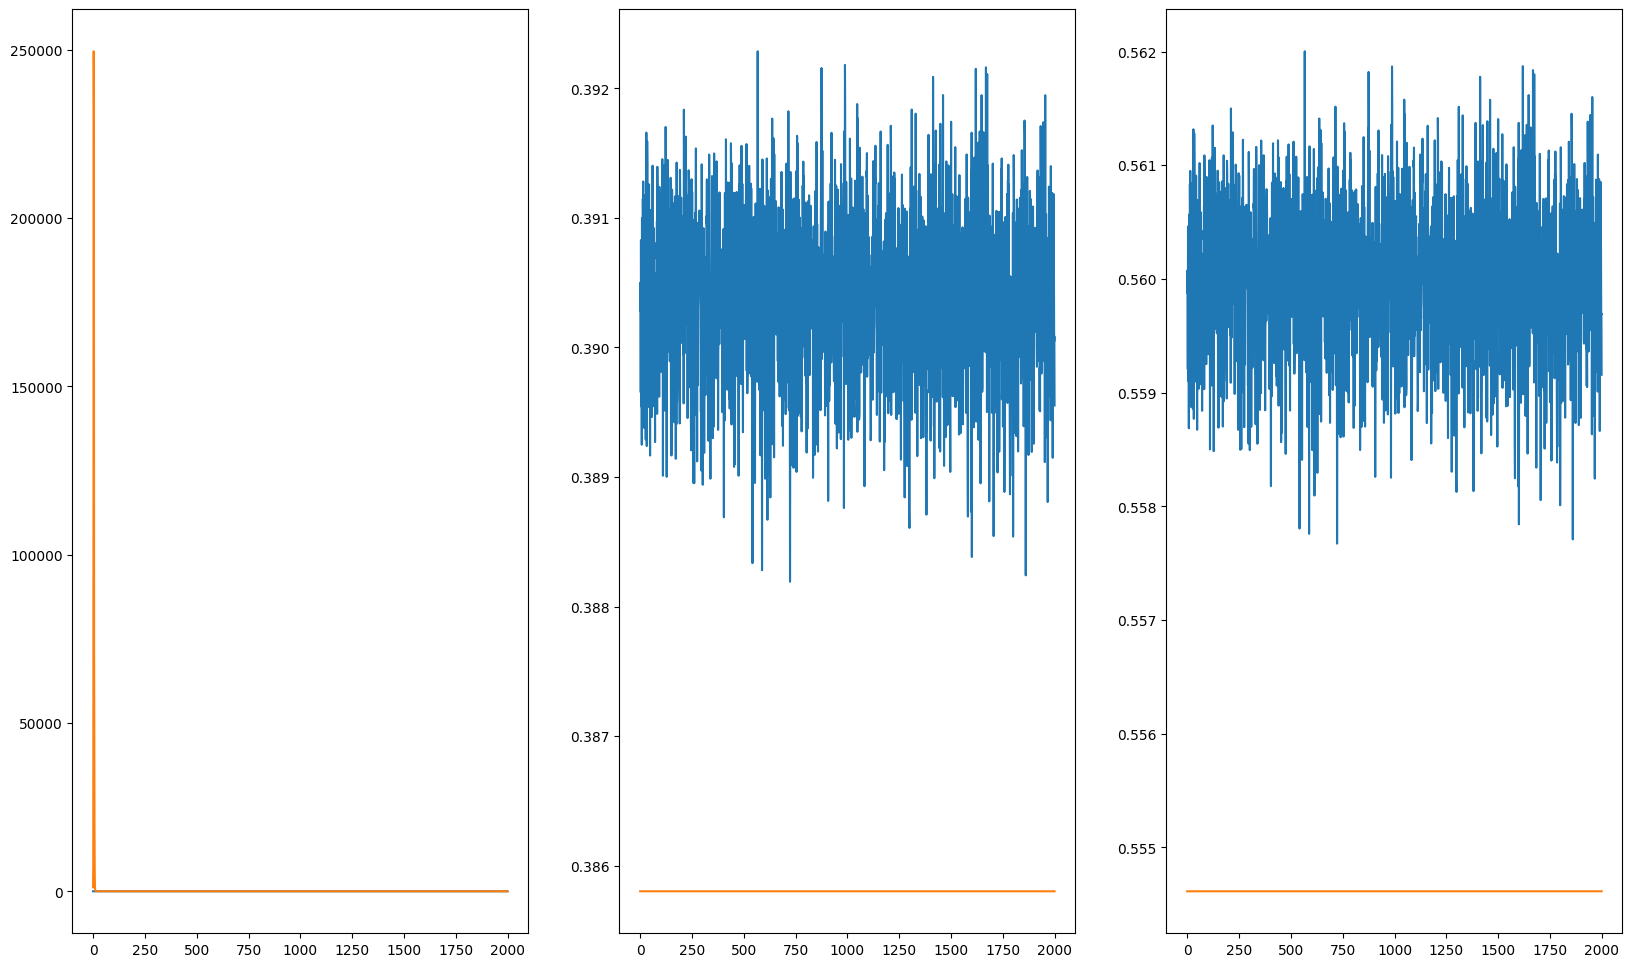

In [29]:
# 5. Train
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=[Jaccard, f1_score])

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="weights.h5",
        monitor="val_f1_score",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1),

    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_f1_score",
    #     min_delta=0.005,
    #     mode="max",
    #     patience=10,
    #     verbose=1),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_f1_score',
        factor=0.5,
        patience=5,
        mode='max',
        min_delta=0.01,
        cooldown=0,
        min_lr=0.0001,
        verbose=1)
]

history = model.fit(train[0], train[1],
                    validation_data=(valid[0], valid[1]),
                    callbacks=callbacks_list,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    )


loss = history.history['loss']
val_loss = history.history['val_loss']
Jaccard = history.history["Jaccard"]
val_Jaccard = history.history["val_Jaccard"]
f1 = history.history["f1_score"]
val_f1 = history.history["val_f1_score"]

epochs_range = range(len(loss))
fig, ax = plt.subplots(1, 3, figsize = (20, 12))
ax[0].plot(epochs_range, loss, label='Training Loss')
ax[0].plot(epochs_range, val_loss, label='Validation Loss')

ax[1].plot(epochs_range, Jaccard, label='Training Jaccard')
ax[1].plot(epochs_range, val_Jaccard, label='Validation Jaccard')

ax[2].plot(epochs_range, f1, label='Training f1-score')
ax[2].plot(epochs_range, val_f1, label='Validation f1-score')
plt.show()

del model, history, train


(215, 2000, 1)
(None, 250, 128) (None, 250, 128)
(None, 500, 64) (None, 500, 64)
(None, 1000, 32) (None, 1000, 32)
(None, 2000, 16) (None, 2000, 16)
1/1 [==============================] - 1s 1s/step


IndexError: ignored

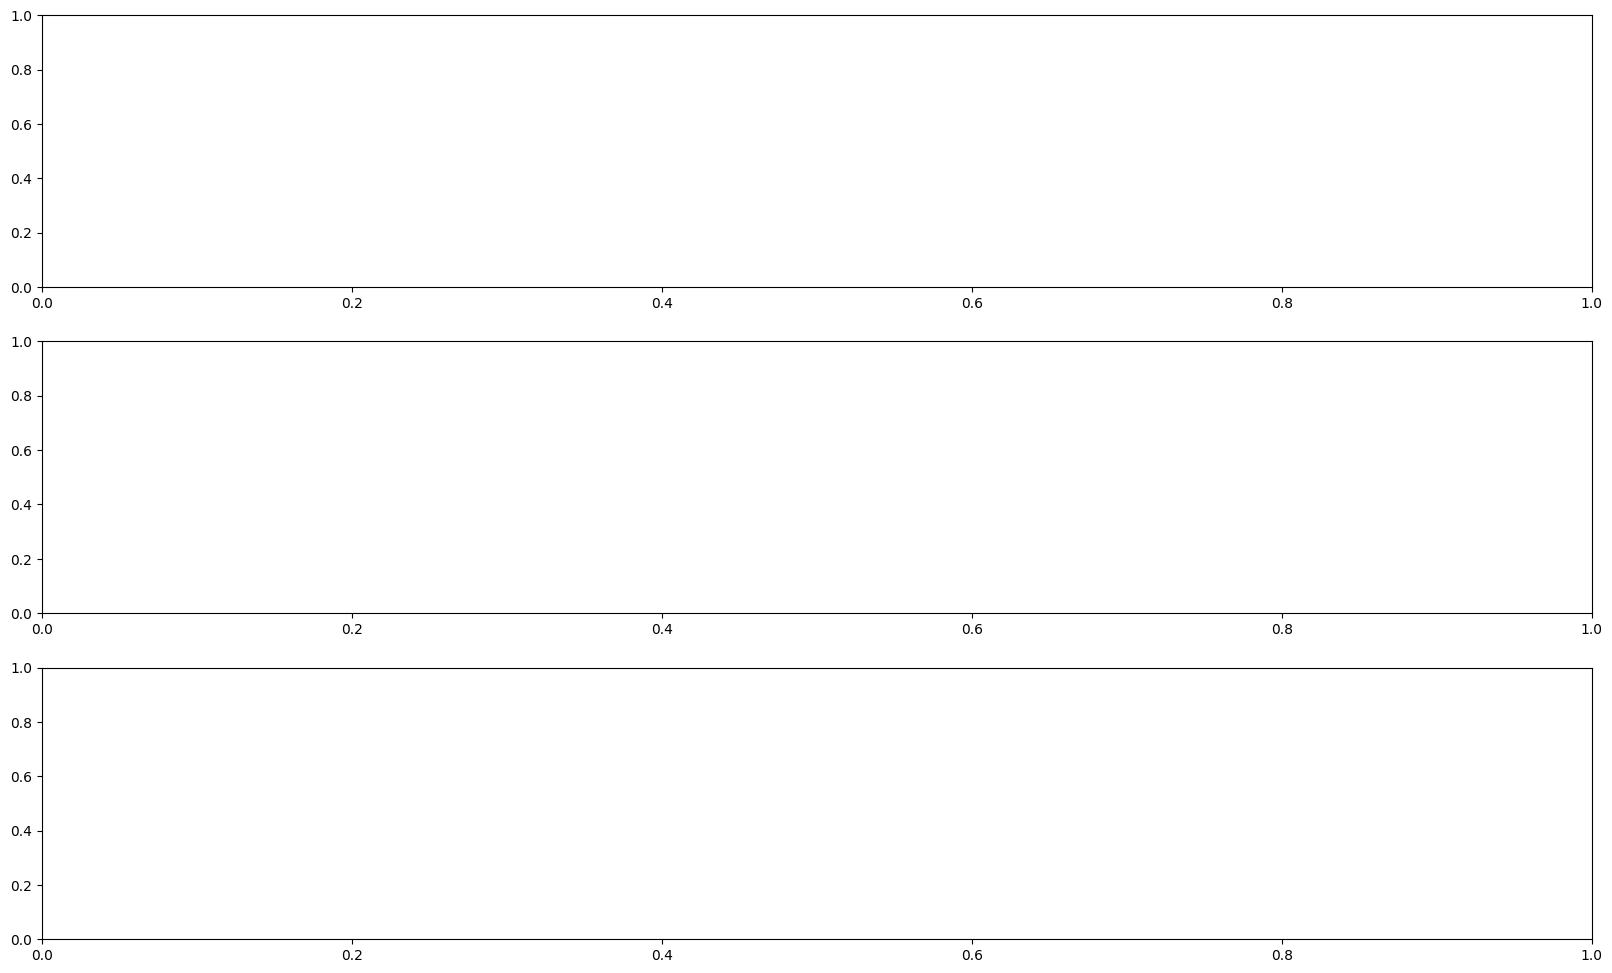

In [30]:
valid = [np.load("valid_x.npy"), np.load("valid_y.npy")]
print(valid[0].shape)

Predict(test=valid)